In [10]:
import pandas as pd
import numpy as np
import psycopg2
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import datetime


In [11]:
conn = psycopg2.connect(host="localhost", database="gastos", user="postgres", password="postgres")

In [12]:
query = '''
select *
from dtm.gastos_fact g
inner join dtm.dia d on d.dia_key = g.dia_key
inner join dtm.subcategoria s on s.subcategoria_key = g.subcategoria_key
'''

In [13]:
df = pd.read_sql_query(query,con=conn)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 2019-10-23 to 2022-02-04
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gastos_fact_key   891 non-null    int64  
 1   importe           891 non-null    float64
 2   dia_key           891 non-null    int64  
 3   subcategoria_key  891 non-null    int64  
 4   saldo             891 non-null    float64
 5   dia               891 non-null    int64  
 6   mes               891 non-null    int64  
 7   anio              891 non-null    int64  
 8   dia_key           891 non-null    int64  
 9   subcategoria_key  891 non-null    int64  
 10  subcategoria      891 non-null    object 
 11  categoria         891 non-null    object 
dtypes: float64(2), int64(8), object(2)
memory usage: 90.5+ KB


# Prepare Data

In [14]:
df = df.set_index("fecha")
df.subcategoria = df.subcategoria.str.strip()
df.categoria = df.categoria.str.strip()

# Fechas de analisis

In [34]:
inicio_filtro = datetime.date(2020, 1, 1)
fin_filtro = datetime.date(2021, 12, 31)

filtro = df[(df.index>=inicio_filtro) & (df.index<=fin_filtro) ]

# Análisis ANUAL

## Gasto total por año

<AxesSubplot:xlabel='anio'>

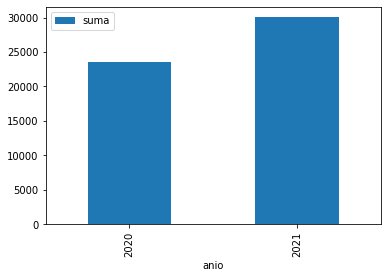

In [44]:
result = filtro.groupby(["anio"]).agg(suma=("importe","sum")).abs()
result.plot.bar()

## Gasto medio mensual

In [47]:
filtro.groupby(["anio","mes"]).agg(suma=("importe","sum")).abs()

suma
anio mes         
2020 1    1354.75
     2    2292.23
     3    1408.41
     4    2131.56
     5    1447.11
     6    1757.02
     7    2051.90
     8    1003.61
     9    1851.49
     10   2276.55
     11   3120.25
     12   2870.67
2021 1    2078.53
     2    2453.64
     3    2823.09
     4    1632.46
     5     426.08
     6    2640.74
     7    1627.16
     8    3660.46
     9    3326.56
     10   2610.81
     11   2959.10
     12   3789.79

# Suma de gastos por mes y año (con tendencia)

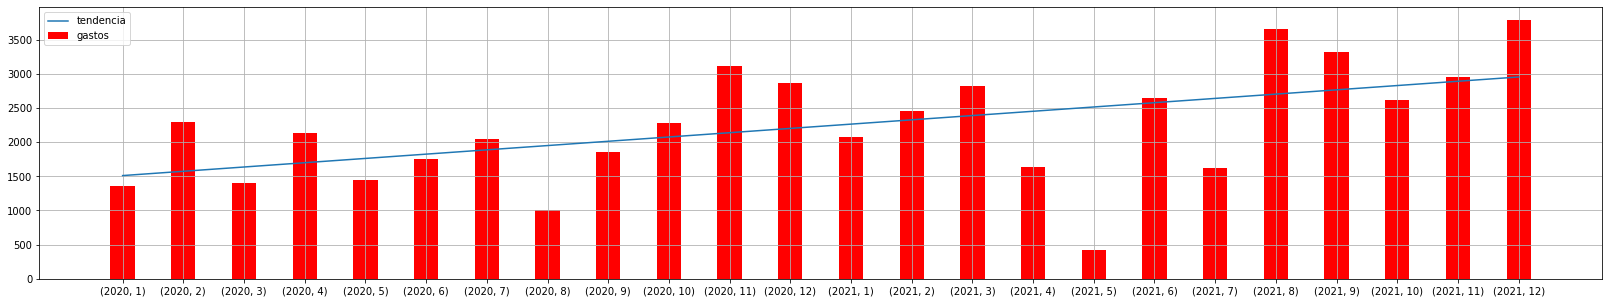

In [35]:
gastos_ac = filtro.groupby(["anio","mes"])["importe"].agg("sum").abs()

#Linear regresion fot trend calculation
X = np.arange(len(gastos_ac.index)).reshape(-1, 1)
y = gastos_ac.to_numpy()

lr = LinearRegression()
lr.fit(X, y)
y_pred = lr.predict(X)

#PLOT
plt.figure(figsize=(28,5))
#plt.bar(x=range(len(ingresos_ac.index)), height=ingresos_ac, label="ingresos", color="g", tick_label=ingresos_ac.index,align="edge", width=-0.4)
plt.bar(x=range(len(gastos_ac.index)), height=gastos_ac.abs(), label="gastos", color="r", tick_label=gastos_ac.index, align="center", width=0.4)
plt.plot(X, y_pred, label = "tendencia")
plt.legend()
plt.grid()


# **Comparativa por años de suma de gastos por mes y año**

<AxesSubplot:xlabel='mes'>

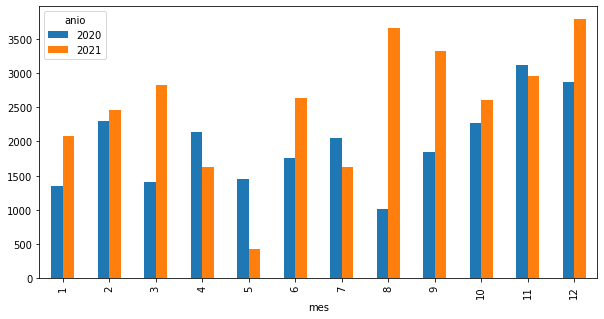

In [36]:
comparativa = filtro.groupby(["mes","anio"])["importe"].agg("sum").abs()
comparativa = comparativa.unstack()
comparativa.plot.bar(figsize=(10,5))

**Media mensual de gastos por año**

anio
2020    1963.795833
2021    2502.368333
2022    3234.245000
Name: importe, dtype: float64


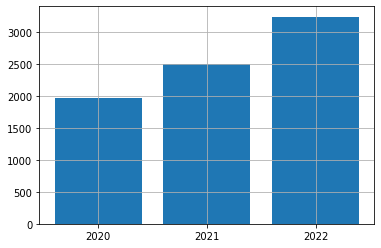

In [19]:
gastos_ac = filtro.groupby(["anio","mes"])["importe"].agg("sum").abs()
gastos_ac2 = gastos_ac.groupby(["anio"]).agg("mean")
plt.bar(gastos_ac2.index,gastos_ac2, tick_label=gastos_ac2.index)
plt.grid()
print(gastos_ac2)

**Desglose por mes y categoria**

<AxesSubplot:xlabel='categoria,anio'>

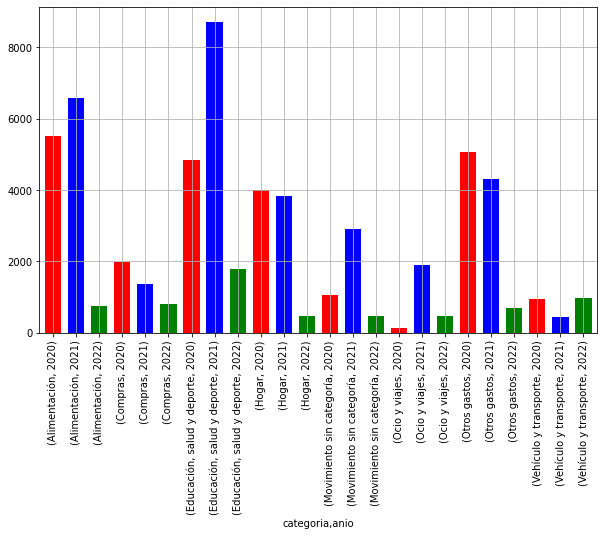

In [23]:
test = filtro.groupby(["anio","categoria"])["importe"].agg("sum").abs()
test2 = test.unstack(fill_value=0)
t = test2.unstack()
t.plot.bar(figsize=(10,6), width=0.7, color=["r","b","g"], grid=True)

# Analisis para la categoría de Educación

<AxesSubplot:xlabel='subcategoria'>

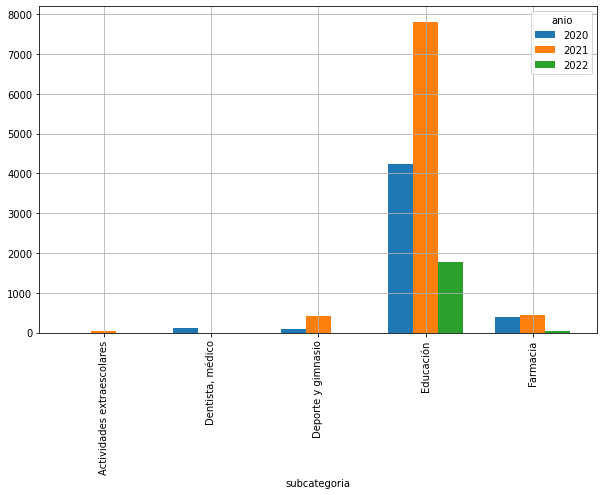

In [33]:
test = filtro[filtro.categoria=='Educación, salud y deporte'].groupby(["subcategoria","anio"])["importe"].agg("sum").abs()
test2 = test.unstack()
test2.plot.bar(figsize=(10,6), width=0.7, grid=True)